<a href="https://colab.research.google.com/github/equador8078/Blogify/blob/main/ema_rsi_lstm_with_and_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.1478 - val_loss: 0.3452
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0414 - val_loss: 0.0058
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0151 - val_loss: 0.0079
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0106 - val_loss: 0.0154
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0097 - val_loss: 0.0589
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0109 - val_loss: 0.0076
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0072 - val_loss: 0.0181
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0070 - val_

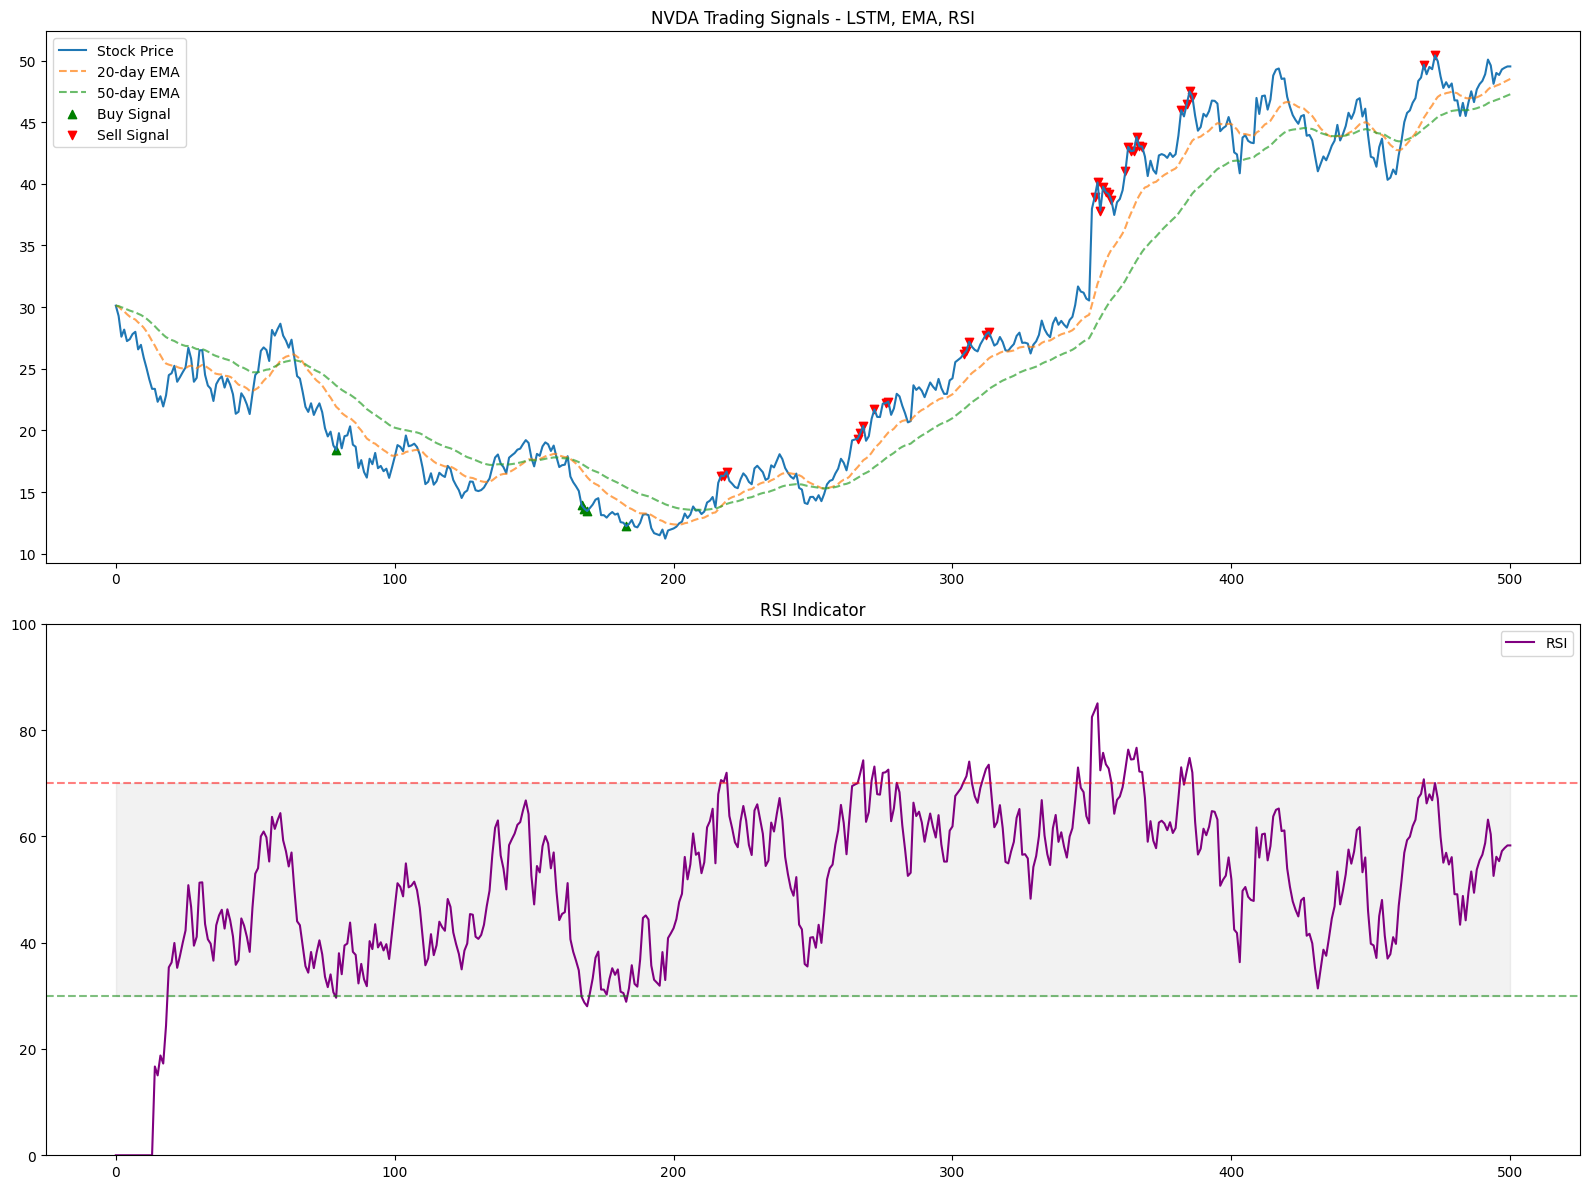


Detailed Trading Signals:
BUY at $18.42 - Reasons: lstm_prediction, rsi_oversold
BUY at $13.94 - Reasons: lstm_prediction, rsi_oversold
BUY at $13.65 - Reasons: lstm_prediction, rsi_oversold
BUY at $13.47 - Reasons: lstm_prediction, rsi_oversold
BUY at $12.23 - Reasons: lstm_prediction, rsi_oversold
SELL at $16.33 - Reasons: lstm_prediction, rsi_overbought
SELL at $16.30 - Reasons: lstm_prediction, rsi_overbought
SELL at $16.67 - Reasons: lstm_prediction, rsi_overbought
SELL at $19.32 - Reasons: lstm_prediction, rsi_overbought
SELL at $19.80 - Reasons: lstm_prediction, rsi_overbought
SELL at $20.36 - Reasons: lstm_prediction, rsi_overbought
SELL at $21.71 - Reasons: lstm_prediction, rsi_overbought
SELL at $22.20 - Reasons: lstm_prediction, rsi_overbought
SELL at $22.34 - Reasons: lstm_prediction, rsi_overbought
SELL at $26.20 - Reasons: lstm_prediction, rsi_overbought
SELL at $26.47 - Reasons: lstm_prediction, rsi_overbought
SELL at $27.19 - Reasons: lstm_prediction, rsi_overbought
SE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yfn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def calculate_ema(prices, period):
    """
    Calculate Exponential Moving Average

    Args:
    prices (np.array): Price series
    period (int): EMA period

    Returns:
    np.array: EMA values
    """
    # Flatten prices to ensure it's 1-dimensional
    prices = prices.flatten()  # This line is added to flatten the array
    return pd.Series(prices).ewm(span=period, adjust=False).mean().values

def calculate_rsi(prices, period=14):
    """
    Calculate Relative Strength Index with full series calculation

    Args:
    prices (np.array): Price series
    period (int): RSI period

    Returns:
    np.array: RSI values
    """
    prices = np.asarray(prices).flatten()

    if len(prices) <= period:
        return np.zeros_like(prices)

    delta = np.diff(prices)
    gains = (delta > 0) * delta
    losses = (delta < 0) * -delta

    avg_gain = np.zeros_like(prices)
    avg_loss = np.zeros_like(prices)

    # Initial smoothed average
    avg_gain[period] = np.mean(gains[:period])
    avg_loss[period] = np.mean(losses[:period])

    # Exponential smoothing for subsequent values
    for i in range(period + 1, len(prices)):
        avg_gain[i] = (avg_gain[i-1] * (period - 1) + gains[i-1]) / period
        avg_loss[i] = (avg_loss[i-1] * (period - 1) + losses[i-1]) / period

    # Relative Strength
    rs = np.zeros_like(prices)
    rs[period:] = avg_gain[period:] / avg_loss[period:]

    # RSI Calculation
    rsi = np.zeros_like(prices)
    rsi[period:] = 100.0 - (100.0 / (1.0 + rs[period:]))

    return rsi

def prepare_lstm_data(prices, lookback_period):
    """
    Prepare data for LSTM model training

    Args:
    prices (np.array): Stock prices
    lookback_period (int): Number of historical time steps to use for prediction

    Returns:
    X_train, y_train, X_test, y_test, scaler
    """
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices.reshape(-1, 1)).flatten()

    # Prepare sequences
    X, y = [], []
    for i in range(lookback_period, len(scaled_prices)):
        X.append(scaled_prices[i-lookback_period:i])
        y.append(scaled_prices[i])

    X, y = np.array(X), np.array(y)

    # Reshape for LSTM input (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test, scaler

def create_lstm_model(lookback_period):
    """
    Create LSTM model for stock price prediction

    Args:
    lookback_period (int): Number of historical time steps

    Returns:
    Compiled Keras model
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(lookback_period, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_lstm_model(model, X_train, y_train, X_test, y_test):
    """
    Train LSTM model

    Args:
    model (keras.Model): Compiled LSTM model
    X_train, y_train: Training data
    X_test, y_test: Test data

    Returns:
    Trained model and training history
    """
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    return model, history

def combine_trading_strategies(prices, lstm_predictions, rsi, ema_20, ema_50,
                                rsi_upper=70, rsi_lower=30,
                                lstm_confidence=0.01, ema_confidence=0.01):
    """
    Combine trading strategies with more nuanced RSI integration

    Args:
    prices (np.array): Stock prices
    lstm_predictions (np.array): LSTM predictions
    rsi (np.array): RSI values
    ema_20 (np.array): 20-day EMA
    ema_50 (np.array): 50-day EMA
    rsi_upper (float): Upper RSI threshold
    rsi_lower (float): Lower RSI threshold
    lstm_confidence (float): Prediction confidence threshold
    ema_confidence (float): EMA crossover confidence threshold

    Returns:
    np.array: Combined trading signals
    list: Detailed trading signals
    """
    signals = np.zeros_like(prices)
    detailed_signals = []

    for i in range(1, len(prices)):
        # LSTM Prediction Signal with confidence
        lstm_buy_signal = lstm_predictions[i] > prices[i-1] * (1 + lstm_confidence)
        lstm_sell_signal = lstm_predictions[i] < prices[i-1] * (1 - lstm_confidence)

        # EMA Crossover Signals
        ema_crossover_buy = (ema_20[i] > ema_50[i] * (1 + ema_confidence)) and (ema_20[i-1] <= ema_50[i-1])
        ema_crossover_sell = (ema_20[i] < ema_50[i] * (1 - ema_confidence)) and (ema_20[i-1] >= ema_50[i-1])

        # RSI Signals with more granular logic
        rsi_oversold = rsi[i] <= rsi_lower
        rsi_overbought = rsi[i] >= rsi_upper

        # Comprehensive buy signal
        if ((lstm_buy_signal and ema_crossover_buy) or
            (rsi_oversold and ema_crossover_buy) or
            (rsi_oversold and lstm_buy_signal)):
            signals[i] = 1
            detailed_signals.append({
                'index': i,
                'type': 'buy',
                'price': prices[i].item() if isinstance(prices[i], np.ndarray) else prices[i],
                'reasons': {
                    'lstm_prediction': lstm_buy_signal,
                    'ema_crossover': ema_crossover_buy,
                    'rsi_oversold': rsi_oversold
                }
            })

        # Comprehensive sell signal
        if ((lstm_sell_signal and ema_crossover_sell) or
            (rsi_overbought and ema_crossover_sell) or
            (rsi_overbought and lstm_sell_signal)):
            signals[i] = -1
            detailed_signals.append({
                'index': i,
                'type': 'sell',
                'price': prices[i].item() if isinstance(prices[i], np.ndarray) else prices[i],
                'reasons': {
                    'lstm_prediction': lstm_sell_signal,
                    'ema_crossover': ema_crossover_sell,
                    'rsi_overbought': rsi_overbought
                }
            })

    return signals, detailed_signals

def calculate_accuracy(y_true, y_pred):
    """
    Calculate multiple accuracy metrics for predictions

    Args:
    y_true (np.array): Actual values
    y_pred (np.array): Predicted values

    Returns:
    dict: Accuracy metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Calculate percentage error
    percentage_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'Mean Absolute Error (MAE)': mae,
        'R-squared (R2) Score': r2,
        'Mean Absolute Percentage Error (MAPE)': percentage_error
    }

def analyze_stock_data_with_lstm_and_indicators(ticker, start_date, end_date, lookback_period=60):
    try:
        # Fetch stock data
        stock_data = yfn.download(ticker, start=start_date, end=end_date)

        if stock_data.empty:
            print(f"No data available for {ticker} between {start_date} and {end_date}")
            return None

        prices = stock_data['Close'].values

        # Check if prices are valid
        if len(prices) < lookback_period:
            print(f"Insufficient data. Need at least {lookback_period} data points.")
            return None

        # Calculate additional indicators
        ema_20 = calculate_ema(prices, 20)
        ema_50 = calculate_ema(prices, 50)
        rsi = calculate_rsi(prices)

        # Prepare LSTM data and model
        X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(prices, lookback_period)
        model = create_lstm_model(lookback_period)

        try:
            model, history = train_lstm_model(model, X_train, y_train, X_test, y_test)
        except Exception as model_error:
            print(f"Error training model: {model_error}")
            return None

        # LSTM Predictions (ensure consistent shape)
        train_predictions = scaler.inverse_transform(model.predict(X_train)).flatten()
        test_predictions = scaler.inverse_transform(model.predict(X_test)).flatten()

        # Calculate accuracy for training and test sets
        train_accuracy = calculate_accuracy(
            scaler.inverse_transform(y_train.reshape(-1, 1)).flatten(),
            train_predictions
        )
        test_accuracy = calculate_accuracy(
            scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
            test_predictions
        )

        # Create full predictions array
        predictions_full = np.zeros_like(prices, dtype=float)
        predictions_full = predictions_full.flatten()

        # Assign predictions to the full array
        predictions_full[lookback_period:lookback_period+len(train_predictions)] = train_predictions
        predictions_full[lookback_period+len(train_predictions):lookback_period+len(train_predictions)+len(test_predictions)] = test_predictions

        # Combine trading strategies
        signals, detailed_signals = combine_trading_strategies(
            prices, predictions_full, rsi, ema_20, ema_50
        )

        # Enhanced Visualization with RSI
        plt.figure(figsize=(16, 12))
        plt.subplot(2, 1, 1)
        plt.plot(prices, label='Stock Price')
        plt.plot(ema_20, label='20-day EMA', linestyle='--', alpha=0.7)
        plt.plot(ema_50, label='50-day EMA', linestyle='--', alpha=0.7)

        buy_signals = prices[signals == 1]
        sell_signals = prices[signals == -1]
        plt.scatter(np.where(signals == 1)[0], buy_signals, color='green', marker='^', label='Buy Signal')
        plt.scatter(np.where(signals == -1)[0], sell_signals, color='red', marker='v', label='Sell Signal')

        plt.title(f'{ticker} Trading Signals - LSTM, EMA, RSI')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(rsi, label='RSI', color='purple')
        plt.axhline(y=70, color='red', linestyle='--', alpha=0.5)
        plt.axhline(y=30, color='green', linestyle='--', alpha=0.5)
        plt.fill_between(range(len(rsi)), 30, 70, color='grey', alpha=0.1)
        plt.title('RSI Indicator')
        plt.ylim(0, 100)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Print detailed signals
        print("\nDetailed Trading Signals:")
        for signal in detailed_signals:
            reasons = [key for key, value in signal['reasons'].items() if value]
            print(f"{signal['type'].upper()} at ${signal['price']:.2f} - Reasons: {', '.join(reasons)}")

        # Print accuracy metrics
        print("\nTraining Set Accuracy Metrics:")
        for metric, value in train_accuracy.items():
            print(f"{metric}: {value}")

        print("\nTest Set Accuracy Metrics:")
        for metric, value in test_accuracy.items():
            print(f"{metric}: {value}")

        return {
            'predictions': predictions_full,
            'signals': signals,
            'detailed_signals': detailed_signals,
            'rsi': rsi,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage
if __name__ == "__main__":
    analyze_stock_data_with_lstm_and_indicators('NVDA', '2022-01-01', '2023-12-31')